In [17]:
using Symbolics
using LinearAlgebra
using Latexify
using Plots

## Fluídos Conformes

Código para testear la estabilidad alrededor de una solución de equilibrio.

Las ecuaciones son:

$(\zeta^a, \zeta^{ab})$ -> $f^j = (\mu, v, x_i)$ -> $(-1,0,0,0,0)$

$$
\partial_t c^j = \partial_i F^{ij}(f) + I^j(f) = \frac{\partial F^{ij}}{\partial f^k}\partial_i f^k
$$

$$
c^j = C^j(f) = (e, S, c_i)
$$

Lo que hacemos es tomar el jacobiano del flujo,

$\frac{\partial F^i}{\partial f^j}$ donde $f^j$ son las variables no conservativas para las cuales tenemos las expresiones del Flujo. 
A estas las multiplicamos por $[\frac{\partial c^k}{\partial f^j}]^{-1}$.
Tenemos así 

$$
P^{il}{}_j := \frac{\partial F^{il}}{\partial c^j} = \frac{\partial F^{il}}{\partial f^k}\frac{\partial f^k}{\partial c^j}.
$$

Evaluamos todo en el vector $(-1,0,0,0,0)$ o sea estamos en el frame con velocidad cero y todas las variables fuera de equilibrio también cero.

Lo mismo hacemos con la fuente. 

$$
II^i{}_j = \frac{\partial I^i}{\partial f^k} \frac{\partial f^k}{\partial c^j}
$$

Tenemos así el sistema linearizado en el punto de equilibrio en las variables conservativas. Multiplicamos $P^i{}_j$ por un número complejo cualquiera y para todos ellos los autovalores debieran tener parte real negativa o nula. Pero no es así...


Alternativamente podemos diferenciar $c^i$ con respecto a los $f^j$ para obtener,

$$
\partial_t c^j = \frac{\partial c^j}{\partial f^i} \partial_t f^i
$$

y por lo tanto,

$$
\partial_t f^i = \frac{\partial c^j}{\partial f^i}^{-1} \frac{\partial F^{lj}}{\partial f^k}\partial_l f^k := \tilde{P}^i{}_k\partial_l f^k
$$

A las que simplemente sumamos el término $\frac{\partial c^j}{\partial f^i}^{-1}\frac{\partial I^j}{\partial f^k}$ para tener el sistema linearizado con respecto a las $f^i$.

In [18]:
function Flux_imp!(Fl,flu,con,p)
    χ = p
    μ = flu[1]  # esto es -μ
    #μ = view(flu,1)
    T = (abs(μ))^(-1//2) # use μ positive, so I changed μ -> -μ
    v = flu[2]
    ν = flu[3]
    r1 = flu[4]
    t11 = flu[5]
    χ₀ = χ[1]
    χ₁ = χ[2]
    χ₂ = χ[3]
    γ = (1 - v^2)^(-1//2)
    T11_0 = -8χ₀*T^4*(γ^2*v^2+1/4)
    T11_1 = χ₁*(-80//3*T^8*ν*(γ^2*v^2+1)  - 20*T^7*r1*γ*v  - 2*T^6*t11)
    T11_2 = χ₂*T^8*(ν^2*(-560*T^4*(γ^2*v^2 + 1//4)) + ν*r1*T^3*(-1120*γ*v) + ν*t11*T^2*(-112)
                    + r1^2*T^2*(364γ^2*v^2*(v^2 -1)-217+49v^2)
                    + r1*t11*T*336*γ*v*(v^2-1)
                    + t11^2*(111 + 126v^2 - 15v^4 - 204γ^2*v^2*(1-v^2)^2)/4)
    Fl[1] = con[2]
    Fl[2] = T11_0 + T11_1 + T11_2
    Fl[3] = con[4]
    Fl[4] = con[5]
    Fl[5] = -3χ₁*γ*v*T^5*(2γ^2*v^2+1) - 12χ₂*(v*T*10*γ*(2γ^2*v^2+1)*ν  + 3*(1+6γ^2*v^2)*r1    
         + 3v*γ*t11/T)
    return -Fl[:]
end



Flux_imp! (generic function with 1 method)

In [19]:
@variables f[1:5], c[1:5], Fl[1:5], p[1:3], r[1:5]

JFS_f = Symbolics.jacobian(Flux_imp!(Fl,f,c,p),f);
JFS_c = Symbolics.jacobian(Flux_imp!(Fl,f,c,p),c);
JF_f_exp = Symbolics.build_function(JFS_f, Fl, f, c, p);
JF_c_exp = Symbolics.build_function(JFS_c, Fl, f, c, p);
JFac_f = eval(JF_f_exp[1]);
JFac_c = eval(JF_c_exp[1]);


In [38]:
re = zeros(5)
fl = zeros(5)
flu=[-1.;0.99;0;0;0];
par_f = [-1.,-0.,-2.]
con = F_alt!(re,flu,zeros(5), par_f);
JFac_f(Fl,flu,con,par_f)
JFac_c(Fl,flu,con,par_f)
Jac_alt(r,flu,con,par_f)

5×5 Matrix{Float64}:
 800.02  39999.0  0.0            0.0    0.0
 795.98  40001.0  0.0            0.0    0.0
   0.0       0.0  1.69285e5  21420.2  500.238
   0.0       0.0  1.68715e5  21396.5  501.939
   0.0       0.0  1.68151e5  21372.7  503.623

In [20]:
include("inversion_ext.jl");
#println(F_alt!([0.;0.;0.;0.;0.],[-1;0.2;3;4;5],[6;7;8;9;10],[1;2;3]))


#151 (generic function with 1 method)

In [47]:
P(r,Fl,flu,c,p) =  JFac_f(Fl,flu,con,p)*inv(Jac_alt(r,flu,con,p)) + JFac_c(Fl,con,flu,p) #var conserv
PT(r,Fl,flu,c,p) = inv(Jac_alt(r,flu,con,p))*(JFac_f(Fl,flu,con,p) + JFac_c(Fl,con,flu,p)*Jac_alt(r,flu,con,p)) #var fluid

PT (generic function with 3 methods)

In [48]:
re = zeros(5)
fl = zeros(5)
flu=[-1.;0.99;0;0;0];
par_f = [-1.,-0.,-2.]
con = F_alt!(re,flu,zeros(5), par_f);
P(re,fl,flu,c,par_f)

5×5 Matrix{Float64}:
 0.0       -1.0       0.0       0.0       0.0
 0.960592  -1.96049   0.0       0.0       0.0
 0.0        0.0       0.0      -1.0       0.0
 0.0        0.0       0.0       0.0      -1.0
 0.0        0.0      -0.91348   2.82609  -2.91261

In [79]:
re = zeros(5)
fl = zeros(5)
flu=[-1.;0.;0;0;0];
par_f = [-1.,-0.,-2.]
con = F_alt!(re,flu,zeros(5), par_f);
eigvals(P(re,fl,flu,con,par_f))

5-element Vector{Float64}:
 -0.7745966692414833
 -0.5773502691896256
  0.0
  0.5773502691896258
  0.7745966692414834

In [80]:
re = zeros(5)
fl = zeros(5)
flu=[-1.;0.;0;0;0];
par_f = [-1.,-0.,-2.]
con = F_alt!(re,flu,zeros(5), par_f);
eigvals(PT(re,fl,flu,con,par_f))

5-element Vector{Float64}:
 -0.7745966692414827
 -0.5773502691896256
 -1.1275702593849246e-17
  0.5773502691896258
  0.7745966692414832

In [87]:
re = zeros(5)
fl = zeros(5)
N = 1000
par_f = [-1,-0.001,-0.1]
#par_f = [-1,-0.5,-20]
E = zeros(5,N)
v = zeros(N)
for i in 1:N
    v[i] = (i-1)/N/1
    flu[2] = v[i]
    con = F_alt!(re,flu,zeros(5), par_f);
    E[:,i]=eigvals(P(re,fl,flu,con,par_f))
    if any(E[:,i].>1.)
        #println(E[:,i], v[i])
    end
end

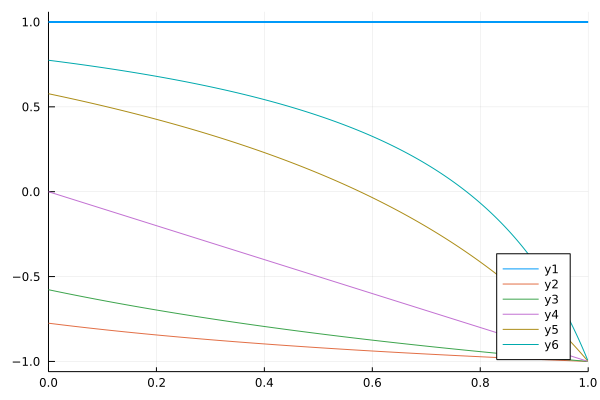

In [88]:
one(x)=1
plot(one,xlim=(0,1),legend=:bottomright, lw=2)
plot!(v,E[1,:])
plot!(v,E[2,:],
legend=:bottomright)
plot!(v,E[3,:])
plot!(v,E[4,:])
plot!(v,E[5,:])

In [56]:
Eu(flu,con,par_f) = P(re,fl,flu,con,par_f)[1:2,1:2]

Eu (generic function with 1 method)

In [83]:
N = 100
par_f = [-1,-0,-2]
Eul = zeros(2,N)
for i in 1:N
    v = (i-1)/N
    flu[2] = v
    con = F_alt!(re,flu,zeros(5), par_f);
    Eul[:,i]=eigvals(Eu(flu,con,par_f))
end

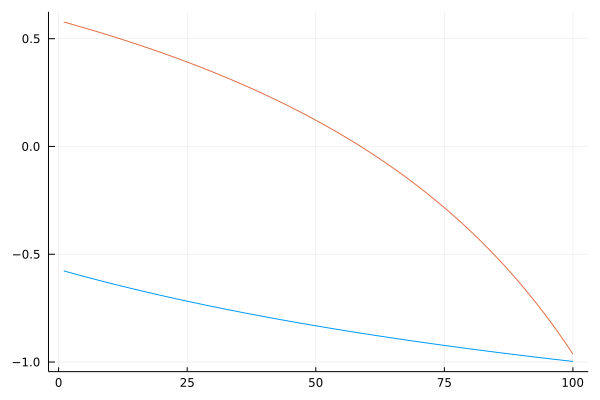

In [84]:
plot(Eul[1,:],
    label=false)
plot!(Eul[2,:],
    label=false)

## Hacemos lo mismo para la fuente.

In [64]:
function Is(flu, χ, ξ)
    #(χ, ξ) = par 
    μ = flu[1] 
    χ₀= χ[1]
    χ₁= -χ[2] # lo hacemos positivo
    κ = ξ[1]χ₀ # χ₀*ξ[1]/χ₁^2 # OK 
    λ = ξ[2]χ₀ #χ₀*ξ[2]/χ₁^2  # OK
    η = ξ[3]χ₀ #χ₀*ξ[3]/χ₁^2
    T = (abs(μ))^(-1//2) # use μ positive, so I changed μ -> -μ
    v = flu[2]
    γ = (1. - v^2)^(-1//2)
    x1 = 10*γ*T/3*flu[3]
    x2 = flu[4]
    x3 = γ/T*flu[5]
    
    #Is[1] = 0.
    #Is[2] = 0.
    #Is[3] = -2//5*a*(γ^2-1//4)*T*x1/(γ*λ) - 2γ*v*x2/T/κ - v^2*T*x3/(γ*λ)
    #Is[4] = -2//5*a*γ*v*T*x1/λ - γ*(v^2+1)*x2/T/κ - v*T*x3/(γ*λ)
    #Is[5] = -2//5*a*(γ^2*v^2+1//4)*T*x1/λ/γ - 2γ*v*x2/T/κ - T*x3/(γ*λ)
    #return Is[:]      #(1 - ℯ^(-5. *t))
    return [0.;
            0.;
            #(-3//10*(γ^2-1//4)*x1/(γ*λ)   + 2γ*v*x2/κ      - v^2*x3/(γ*η))/μ^4/T;
            #(-3//10*γ*v*x1/λ              + γ*(v^2+1)*x2/κ - v*x3/(γ*η))/μ^4/T;
            #(-3//10*(γ^2*v^2+1//4)*x1/λ/γ + 2γ*v*x2/κ      - x3/(γ*η))/μ^4/T;
            #-2//5*(γ^2-1//4)*T*x1/(γ*λ) - 2γ*v*x2/T/κ - v^2*T*x3/(γ*η);
            #-2//5*γ*v*T*x1/λ - γ*(v^2+1)*x2/T/κ - v*T*x3/(γ*η);
            #-2//5*(γ^2*v^2+1//4)*T*x1/η/γ - 2γ*v*x2/T/κ + T*x3/(γ*η)
            #-2//5*(γ^2-1//4)*T*x1/(γ*λ) - 2γ*v*x2/T/κ - v^2*T*x3/(γ*λ);
            #-2//5*γ*v*T*x1/λ - γ*(v^2+1)*x2/T/κ - v*T*x3/(γ*λ);
            #-2//5*(γ^2*v^2+1//4)*T*x1/λ/γ - 2γ*v*x2/T/κ - T*x3/(γ*λ)
            (-3//10*(γ^2    -1//4)*x1/λ         + 2γ*v*x2/κ/T      - μ*v^2*x3/η)/μ^5;
            (-3//10*(γ^2*v  + 0  )*x1/λ         + γ*(v^2+1)*x2/κ/T - μ*v*x3/η)/μ^5;
            (-3//10*(γ^2*v^2+1//4)*x1/λ         + 2γ*v*x2/κ/T      - μ*x3/η)/μ^5;
            ]
end

Is (generic function with 1 method)

In [65]:
@variables q[1:3]  
Is(f,p,q);

In [66]:
JSS = Symbolics.jacobian(Is(f,p,q),f);

In [67]:
JS_exp = Symbolics.build_function(JSS, f, p,q);

In [68]:
JSac = eval(JS_exp[1]);

In [90]:
II(r,flu,c,p,q) = JSac(flu,p,q)*inv(Jac_alt(r,flu,con,p))

II (generic function with 2 methods)

In [125]:
N = 100
par_f = [-1,-1,-20.]
par_s = [-1/15/π, 1/π, -1/π]
ET = fill(1.0+0*im,5,N)
v = zeros(N)
for i in 1:N
    v[i] = (i-1)/N/1
    flu[2] = v[i]
    con = F_alt!(re,flu,zeros(5), par_f);
    ET[:,i]=eigvals(1.0*im * P(re,fl,flu,con,par_f) + 1.0*II(r,flu,con,par_f,par_s))
    if any(imag.(ET[:,i]).>1.)
        #println(imag.(ET[:,i]), v[i])
    end
    if any(real.(ET[:,i]).>0.)
        #println(real.(ET[:,i]), v[i])
    end
end


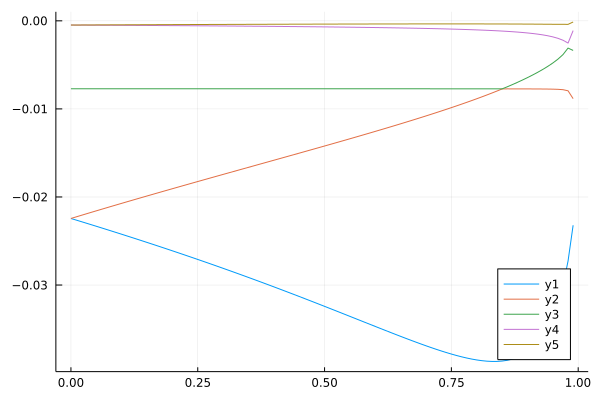

In [126]:
plot(legend=:bottomright)
for i in 1:5
    plot!(v,real.(ET[i,:])
        #,ylims=(-0.01,0.001)
    )
end
current()

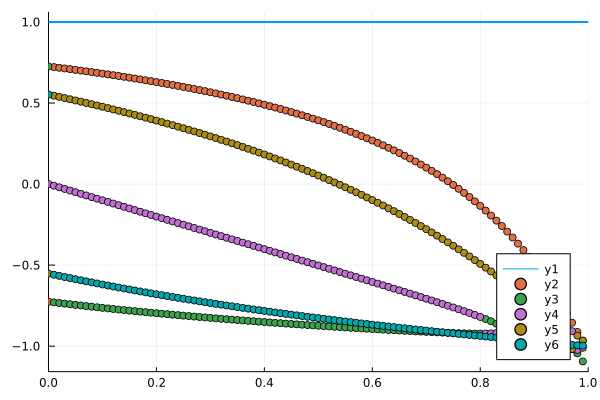

In [124]:
#one(x)=1
plot(one,xlim=(0,1),legend=:bottomright, lw=2)
for i in 1:5
    scatter!(v,imag.(ET[i,:]))
end
current()